In [14]:
# نصب کتابخانه موردنیاز
!pip install scikit-learn


In [15]:
# بارگذاری داده‌ها و آماده‌سازی
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# بارگذاری دیتاست MovieLens 100K
columns = ['userId', 'movieId', 'rating', 'timestamp']
ratings = pd.read_csv('https://files.grouplens.org/datasets/movielens/ml-100k/u.data',
                      sep='\t', names=columns)

# ساخت ماتریس user-movie
user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')

# جای‌گذاری مقادیر گمشده با میانگین هر کاربر
imputer = SimpleImputer(strategy='mean')
filled_matrix = pd.DataFrame(imputer.fit_transform(user_movie_matrix),
                             index=user_movie_matrix.index,
                             columns=user_movie_matrix.columns)

# نرمال‌سازی ویژگی‌ها
scaler = StandardScaler()
scaled_matrix = pd.DataFrame(scaler.fit_transform(filled_matrix),
                             index=filled_matrix.index,
                             columns=filled_matrix.columns)


In [26]:
# بارگذاری اطلاعات فیلم‌ها برای اضافه کردن نام آن‌ها
movies_cols = ['movieId', 'title']
movies = pd.read_csv('https://files.grouplens.org/datasets/movielens/ml-100k/u.item',
                     sep='|', encoding='latin-1', names=movies_cols, usecols=[0, 1])


In [16]:
# خوشه‌بندی کاربران با KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(scaled_matrix)
cluster_labels = pd.Series(clusters, index=scaled_matrix.index)


In [17]:
# تابع توصیه‌گر برای کاربران بر اساس خوشه
def cluster_recommend(user_id, top_n=5):
    user_cluster = cluster_labels[user_id]
    cluster_users = cluster_labels[cluster_labels == user_cluster].index
    cluster_ratings = user_movie_matrix.loc[cluster_users]
    avg_ratings = cluster_ratings.mean().sort_values(ascending=False)
    seen_movies = user_movie_matrix.loc[user_id].dropna().index
    recommendations = avg_ratings.drop(seen_movies).head(top_n)
    return recommendations


In [18]:
# تست تابع برای کاربر مشخص (مثلاً کاربر شماره 10)
user_id = 10
print(f"Top recommendations for user {user_id}:")
print(cluster_recommend(user_id))


Top recommendations for user 10:
movieId
1653    5.0
1500    5.0
1599    5.0
1201    5.0
1189    5.0
dtype: float64


In [19]:
# نصب کتابخانه‌ها
!pip install scikit-learn ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.5 MB/s eta 0:00:00


In [20]:
# بارگذاری و آماده‌سازی داده‌ها
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

columns = ['userId', 'movieId', 'rating', 'timestamp']
ratings = pd.read_csv('https://files.grouplens.org/datasets/movielens/ml-100k/u.data',
                      sep='\t', names=columns)

user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')

imputer = SimpleImputer(strategy='mean')
filled_matrix = pd.DataFrame(imputer.fit_transform(user_movie_matrix),
                             index=user_movie_matrix.index,
                             columns=user_movie_matrix.columns)

scaler = StandardScaler()
scaled_matrix = pd.DataFrame(scaler.fit_transform(filled_matrix),
                             index=filled_matrix.index,
                             columns=filled_matrix.columns)


In [21]:
# خوشه‌بندی کاربران با KMeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(scaled_matrix)
cluster_labels = pd.Series(clusters, index=scaled_matrix.index)


In [27]:
def cluster_recommend(user_id, top_n=5):
    user_cluster = cluster_labels[user_id]
    cluster_users = cluster_labels[cluster_labels == user_cluster].index
    cluster_ratings = user_movie_matrix.loc[cluster_users]

    # محاسبه میانگین امتیاز فیلم‌ها و حذف NaNها
    avg_ratings = cluster_ratings.mean().dropna()

    # حذف فیلم‌هایی که کاربر دیده
    seen_movies = user_movie_matrix.loc[user_id].dropna().index
    unseen_ratings = avg_ratings.drop(seen_movies, errors='ignore')

    # انتخاب top_n فیلم با بالاترین میانگین امتیاز
    top_movies = unseen_ratings.sort_values(ascending=False).head(top_n)

    # اتصال به نام فیلم‌ها
    recommendations = pd.DataFrame({
        'movieId': top_movies.index,
        'predicted_rating': top_movies.values
    }).merge(movies, on='movieId', how='left')

    return recommendations[['title', 'predicted_rating']]




In [32]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def user_based_fallback(user_id, top_n=5):
    # محاسبه شباهت تمام کاربران به هم
    similarity_matrix = cosine_similarity(user_movie_matrix.fillna(0))
    similarity_df = pd.DataFrame(similarity_matrix, index=user_movie_matrix.index, columns=user_movie_matrix.index)

    # شباهت‌های کاربر فعلی به دیگران
    similar_users = similarity_df[user_id].drop(user_id).sort_values(ascending=False)

    # انتخاب top 5 کاربر مشابه
    top_similar_users = similar_users.head(5).index
    similar_ratings = user_movie_matrix.loc[top_similar_users]

    # میانگین امتیاز کاربران مشابه
    avg_ratings = similar_ratings.mean().dropna()

    # حذف فیلم‌هایی که کاربر فعلی دیده
    seen_movies = user_movie_matrix.loc[user_id].dropna().index
    recommendations = avg_ratings.drop(seen_movies, errors='ignore').sort_values(ascending=False).head(top_n)

    # اتصال به عنوان فیلم
    recommendations_df = pd.DataFrame({
        'movieId': recommendations.index,
        'predicted_rating': recommendations.values
    }).merge(movies, on='movieId', how='left')

    return recommendations_df[['title', 'predicted_rating']]


In [33]:
def hybrid_recommend(user_id, top_n=5):
    recs = cluster_recommend(user_id, top_n=top_n)

    # اگر خروجی خالی بود، از روش fallback استفاده کن
    if recs.empty:
        print(f"⚠️ No cluster-based recommendations for user {user_id}. Using user similarity instead.")
        recs = user_based_fallback(user_id, top_n=top_n)

    return recs


In [34]:
def on_button_clicked(b):
    with output:
        output.clear_output()
        user_id = user_dropdown.value
        recs = hybrid_recommend(user_id)
        print(f"🎯 Top Recommendations for User {user_id}:")
        display(recs)


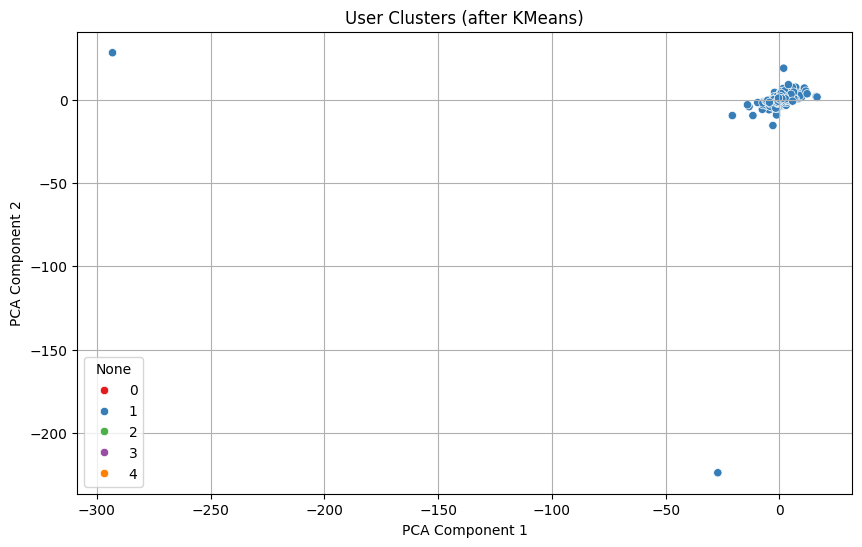

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

# کاهش ابعاد با PCA برای نمایش کاربران روی نمودار دوبعدی
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_matrix)

plt.figure(figsize=(10,6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=cluster_labels, palette="Set1", legend='full')
plt.title("User Clusters (after KMeans)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


In [35]:
# رابط گرافیکی برای انتخاب کاربر
import ipywidgets as widgets
from IPython.display import display

user_dropdown = widgets.Dropdown(
    options=sorted(user_movie_matrix.index),
    description='User ID:',
    value=1
)

recommend_button = widgets.Button(description="Get Recommendations")

output = widgets.Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        user_id = user_dropdown.value
        recs = cluster_recommend(user_id)
        print(f"Top Recommendations for User {user_id}:")
        print(recs)

recommend_button.on_click(on_button_clicked)

display(user_dropdown, recommend_button, output)


Dropdown(description='User ID:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2…

Button(description='Get Recommendations', style=ButtonStyle())

Output()

In [36]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics.pairwise import cosine_similarity

# تابع پشتیبان با cosine similarity
def user_based_fallback(user_id, top_n=5):
    similarity_matrix = cosine_similarity(user_movie_matrix.fillna(0))
    similarity_df = pd.DataFrame(similarity_matrix, index=user_movie_matrix.index, columns=user_movie_matrix.index)
    similar_users = similarity_df[user_id].drop(user_id).sort_values(ascending=False)
    top_similar_users = similar_users.head(5).index
    similar_ratings = user_movie_matrix.loc[top_similar_users]
    avg_ratings = similar_ratings.mean().dropna()
    seen_movies = user_movie_matrix.loc[user_id].dropna().index
    recommendations = avg_ratings.drop(seen_movies, errors='ignore').sort_values(ascending=False).head(top_n)
    recommendations_df = pd.DataFrame({
        'movieId': recommendations.index,
        'predicted_rating': recommendations.values
    }).merge(movies, on='movieId', how='left')
    return recommendations_df[['title', 'predicted_rating']]

# تابع خوشه‌بندی
def cluster_recommend(user_id, top_n=5):
    user_cluster = cluster_labels[user_id]
    cluster_users = cluster_labels[cluster_labels == user_cluster].index
    cluster_ratings = user_movie_matrix.loc[cluster_users]
    avg_ratings = cluster_ratings.mean().dropna()
    seen_movies = user_movie_matrix.loc[user_id].dropna().index
    unseen_ratings = avg_ratings.drop(seen_movies, errors='ignore')
    top_movies = unseen_ratings.sort_values(ascending=False).head(top_n)
    recommendations = pd.DataFrame({
        'movieId': top_movies.index,
        'predicted_rating': top_movies.values
    }).merge(movies, on='movieId', how='left')
    return recommendations[['title', 'predicted_rating']]

# تابع نهایی ترکیبی
def hybrid_recommend(user_id, top_n=5):
    recs = cluster_recommend(user_id, top_n=top_n)
    if recs.empty:
        print(f"⚠️ No cluster-based recommendations for user {user_id}. Using user similarity instead.")
        recs = user_based_fallback(user_id, top_n=top_n)
    return recs

# ساخت رابط گرافیکی
user_dropdown = widgets.Dropdown(
    options=sorted(user_movie_matrix.index.tolist()),
    description='User ID:',
    value=13,
    layout=widgets.Layout(width='200px')
)
output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output()
        user_id = user_dropdown.value
        recs = hybrid_recommend(user_id)
        print(f"🎯 Top Recommendations for User {user_id}:")
        display(recs)

recommend_button = widgets.Button(description="Get Recommendations", button_style='success')
recommend_button.on_click(on_button_clicked)

display(widgets.VBox([user_dropdown, recommend_button, output]))
